In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from Utils.Optuna import optuna_hyperparameter_tuning
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
from catboost import CatBoostRegressor, Pool
import numpy as np
from pipeline import Pipeline

2024-03-28 00:21:19.089 | INFO     | preprocessing.abstract_prep:<module>:6 - Successfully imported file
2024-03-28 00:21:19.089 | INFO     | preprocessing.check_nans:<module>:7 - Successfully imported file
2024-03-28 00:21:19.104 | INFO     | preprocessing.minmax_scaler:<module>:8 - Successfully imported 'MinMaxScaler' file
2024-03-28 00:21:19.440 | INFO     | preprocessing.check_and_remove_outliers:<module>:6 - Successfully imported 'CheckAndRemoveOutliers' file


In [2]:
data = pd.read_csv("Data/cleaned_data.csv")
columns = pd.read_json("Data/selected_features_15.json")[0]

In [3]:
pipeline = Pipeline(data, CatBoostRegressor)
data_preprocessed = pipeline.data_preprocessing(data)
X = data_preprocessed[columns]
y = data_preprocessed['CREDIT_SCORE']
X.shape

2024-03-27 23:30:47.409 | INFO     | pipeline:data_preprocessing:24 - Data Preprocessing
2024-03-27 23:30:47.409 | INFO     | preprocessing.check_nans:transform:52 - CheckNans is starting
2024-03-27 23:30:47.413 | INFO     | preprocessing.check_nans:transform:55 - No NaNs in dataframe
2024-03-27 23:30:47.662 | INFO     | preprocessing.check_and_remove_outliers:transform:44 - Number of outliers in dataframe: 23
2024-03-27 23:30:47.662 | ERROR    | preprocessing.minmax_scaler:transform:77 - _MinMaxScaler preprocessing class_ is not fitted yet. Please call 'fit' with training data before transforming.
2024-03-27 23:30:47.662 | INFO     | preprocessing.minmax_scaler:transform:88 - _MinMaxScaler preprocessing class_ is starting transformation
2024-03-27 23:30:47.662 | INFO     | preprocessing.minmax_scaler:transform:91 - _MinMaxScaler preprocessing class_ transformation ended
2024-03-27 23:30:47.676 | INFO     | pipeline:data_preprocessing:33 - Data Preprocessing completed


(877, 37)

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

((630, 37), (630,), (176, 37), (176,), (71, 37), (71,))

<Axes: xlabel='CREDIT_SCORE', ylabel='Count'>

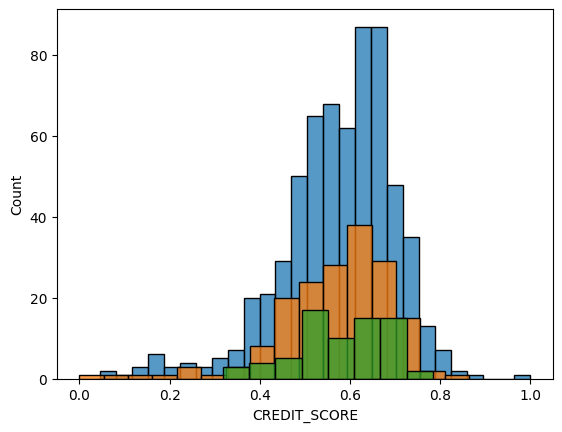

In [5]:
import seaborn as sns
sns.histplot(y_train)
sns.histplot(y_valid)
sns.histplot(y_eval)

In [6]:
# def objective(trial):
#     param = {}
#     param['learning_rate'] = trial.suggest_loguniform("learning_rate", 0.001, 1)
#     param['depth'] = trial.suggest_int('depth', 3, 15)
#     param['l2_leaf_reg'] = trial.suggest_loguniform('l2_leaf_reg', 0.01, 10)
#     param['min_child_samples'] = trial.suggest_int('min_child_samples', 1, 50)
#     param['grow_policy'] = 'Depthwise'
#     param['iterations'] = trial.suggest_int('iterations', 100, 2000)
#     param['use_best_model'] = True
#     param['eval_metric'] = 'RMSE'
#     param['od_type'] = 'iter'
#     param['od_wait'] = 20
#     param['logging_level'] = 'Silent'
    
#     regressor = CatBoostRegressor(**param)

#     regressor.fit(X_train.copy(), y_train.copy(),
#                   eval_set=[(X_eval.copy(), y_eval.copy())],
#                   early_stopping_rounds=10)
#     loss = mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
#     return loss


In [7]:
# {
#     'learning_rate': 0.6063757568124354,
#     'depth': 6,
#     'l2_leaf_reg': 7.17402991755073,
#     'min_child_samples': 32,
#     'iterationsc': 835
# }

In [12]:
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform("learning_rate", 0.001, 1),
        'depth': trial.suggest_int('depth', 3, 15),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.01, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'grow_policy': 'Depthwise',
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'use_best_model': True,
        'eval_metric': 'RMSE',
        'od_type': 'iter',
        'od_wait': 20,
        'logging_level': 'Silent'
    }
    
    regressor = CatBoostRegressor(**params)
    
    regressor.fit(
        X_train, y_train,
        eval_set=[(X_eval, y_eval)],
        early_stopping_rounds=10,
        verbose=False
    )
    
    y_pred = regressor.predict(X_valid)
    loss = mean_squared_error(y_valid, y_pred)
    
    return loss

study = optuna.create_study(study_name='catboost_optimization', direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)

if len(study.trials) > 0:
    print("Best trial:")
    best_trial = study.best_trial
    print("  Value: {}".format(best_trial.value))
    print("  Params: ")
    for key, value in best_trial.params.items():
        print("    {}: {}".format(key, value))
else:
    print("No trials have been completed.")


[I 2024-03-27 23:27:51,884] A new study created in memory with name: catboost_optimization
C:\Users\Gor78\AppData\Local\Temp\ipykernel_5712\3575587929.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 0.001, 1),
C:\Users\Gor78\AppData\Local\Temp\ipykernel_5712\3575587929.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.01, 10),
[I 2024-03-27 23:27:54,065] Trial 2 finished with value: 0.0034287813701143494 and parameters: {'learning_rate': 0.1998567677133348, 'depth': 14, 'l2_leaf_reg': 7.151486973108062, 'min_child_samples': 30, 'iterations': 1531}. 

In [9]:
# %%time
# study = optuna.create_study(study_name=f'catboost-seed{42}')
# study.optimize(objective, n_trials=5000, n_jobs=-1, timeout=2400)

In [10]:
study.best_value

0.003627893534849309

In [11]:
study.best_params


{'learning_rate': 0.010915165026927024,
 'depth': 11,
 'l2_leaf_reg': 0.9010947650779054,
 'min_child_samples': 50,
 'iterations': 1316}

In [12]:
# {
#     'learning_rate': 0.6063757568124354,
#     'depth': 6,
#     'l2_leaf_reg': 7.17402991755073,
#     'min_child_samples': 32,
#     'iterations': 835
# }
# Training set metrics:
# 0.0020861356718066227
# 0.8788832890998062
# 0.03443580505288086
# 0.04567423422244343
# Validation set metrics:
# 0.0035043265612778513
# 0.7912041150041146
# 0.041729216269541645
# 0.05919735265430247
# 993.3872607256602
# predicted = MinMaxScaling().inverse_transform(pred_valid)
# actual = MinMaxScaling().inverse_transform(y_valid)
# print(mean_squared_error(actual, predicted))
# print(r2_score(actual, predicted))
# print(mean_absolute_error(actual, predicted))
# print(np.sqrt(mean_squared_error(actual, predicted)))
# 0.7804104782312765
# 22.93352241907153
# 31.51804658803683

In [81]:
train_data = pd.read_csv("Data/cleaned_data.csv")
test_data = pd.read_csv("Data/test_100.csv")
train_data.shape, test_data.shape

((900, 85), (100, 85))

In [82]:
X_test = test_data.drop("CREDIT_SCORE", axis=1)
y_test = test_data["CREDIT_SCORE"]

In [83]:
X = train_data.drop("CREDIT_SCORE", axis=1)
y = train_data["CREDIT_SCORE"]

In [84]:
from catboost import CatBoostRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(learning_rate=0.0037945676929392693,
                                        depth=3,
                                        l2_leaf_reg=0.17795008128571876,
                                        min_child_samples=42,
                                        grow_policy='Depthwise',
                                        iterations=1254,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=0,
                                        logging_level='Silent'
                                        )

# Fit the model on the training data
catboost_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=10)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(mean_absolute_percentage_error(y_test, y_pred))


1050.2792108673304
0.7870158645057194
23.313899710018774
32.4080115228832
0.04009874128275656


In [26]:
train_data = pd.read_csv("Data/cleaned_data.csv")
test_data = pd.read_csv("Data/test_100.csv")
data = pd.concat([train_data, test_data], axis=0)

In [27]:
data

INCOME  SAVINGS     DEBT  R_SAVINGS_INCOME  R_DEBT_INCOME  R_DEBT_SAVINGS  \
0    33269        0   532304            0.0000        16.0000          1.2000   
1    77158    91187   315648            1.1818         4.0909          3.4615   
2    30917    21642   534864            0.7000        17.3000         24.7142   
3    80657    64526   629125            0.8000         7.8000          9.7499   
4   149971  1172498  2399531            7.8182        16.0000          2.0465   
..     ...      ...      ...               ...            ...             ...   
95  246648   756387   493296            3.0667         2.0000          0.6522   
96  127823   660418  1661696            5.1667        13.0000          2.5161   
97   90168    18034   234437            0.2000         2.6000         12.9997   
98  256740   770221  2347341            3.0000         9.1429          3.0476   
99  125522   182578   821599            1.4545         6.5455          4.5000   

    T_CLOTHING_12  T_CLOTHING_6  R_CLOTHING  R_CLOTHING_INCOME  ...  \
0            1889           945      0.5003             0.0568  ...   
1            5818           111      0.0191             0.0754  ...   
2            1157           860      0.7433             0.0374  ...   
3            6857          3686      0.5376             0.0850  ...   
4            1978           322      0.1628             0.0132  ...   
..            ...           ...         ...                ...  ...   
95           6309          4792      0.7595             0.0256  ...   
96           4186           682      0.1629             0.0327  ...   
97           5121          2671      0.5216             0.0568  ...   
98          15648          6901      0.4410             0.0609  ...   
99           5807          1920      0.3306             0.0463  ...   

    R_EXPENDITURE_INCOME  R_EXPENDITURE_SAVINGS  R_EXPENDITURE_DEBT  \
0                 1.0000                 0.0000              0.0625   
1                 0.9091                 0.7692              0.2222   
2                 1.0000                 1.4286              0.0578   
3                 1.0000                 1.2500              0.1282   
4                 0.9091                 0.1163              0.0568   
..                   ...                    ...                 ...   
95                0.6667                 0.2174              0.3333   
96                0.8333                 0.1613              0.0641   
97                1.0000                 4.9999              0.3846   
98                0.7143                 0.2381              0.0781   
99                0.9091                 0.6250              0.1389   

    CAT_GAMBLING  CAT_DEBT  CAT_CREDIT_CARD  CAT_MORTGAGE  \
0              2         1                0             0   
1              0         1                0             0   
2              2         1                0             0   
3              2         1                0             0   
4              2         1                1             1   
..           ...       ...              ...           ...   
95             0         1                0             1   
96             0         1                1             0   
97             2         1                0             0   
98             0         1                1             0   
99             0         1                0             1   

    CAT_SAVINGS_ACCOUNT  CAT_DEPENDENTS  CREDIT_SCORE  
0                     0               0           444  
1                     1               0           625  
2                     1               0           469  
3                     1               0           559  
4                     1               1           473  
..                  ...             ...           ...  
95                    1               0           623  
96                    1               1           561  
97                    1               0           590  
98                    1         

In [28]:
pipeline = Pipeline(data, CatBoostRegressor)
data_preprocessed = pipeline.data_preprocessing(data)
X = data_preprocessed.drop("CREDIT_SCORE", axis=1)
y = data_preprocessed['CREDIT_SCORE']
X.shape, y.shape

2024-03-28 00:34:35.339 | INFO     | pipeline:data_preprocessing:24 - Data Preprocessing
2024-03-28 00:34:35.341 | INFO     | preprocessing.check_nans:transform:52 - CheckNans is starting
2024-03-28 00:34:35.344 | INFO     | preprocessing.check_nans:transform:55 - No NaNs in dataframe
2024-03-28 00:34:35.572 | INFO     | preprocessing.check_and_remove_outliers:transform:44 - Number of outliers in dataframe: 33
2024-03-28 00:34:35.588 | ERROR    | preprocessing.minmax_scaler:transform:77 - _MinMaxScaler preprocessing class_ is not fitted yet. Please call 'fit' with training data before transforming.
2024-03-28 00:34:35.592 | INFO     | preprocessing.minmax_scaler:transform:88 - _MinMaxScaler preprocessing class_ is starting transformation
2024-03-28 00:34:35.605 | INFO     | preprocessing.minmax_scaler:transform:91 - _MinMaxScaler preprocessing class_ transformation ended
2024-03-28 00:34:35.605 | INFO     | pipeline:data_preprocessing:33 - Data Preprocessing completed


((967, 84), (967,))

In [33]:
# Split the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(learning_rate=0.0037945676929392693,
                                        depth=3,
                                        l2_leaf_reg=0.17795008128571876,
                                        min_child_samples=42,
                                        grow_policy='Depthwise',
                                        iterations=1254,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=0,
                                        logging_level='Silent'
                                        )

# Fit the model on the training data
catboost_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50, verbose=100)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(mean_absolute_percentage_error(y_test, y_pred))


0.0031015616152512424
0.7947949975654416
0.04150980975704673
0.05569166558158629
0.08523434929205893


In [34]:
from preprocessing.minmax_scaler import MinMaxScaling
pred_test = MinMaxScaling().inverse_transform(y_pred)
y_test = MinMaxScaling().inverse_transform(y_test)
print("mse: ", mean_squared_error(y_test, pred_test))
print("r2: ", r2_score(y_test, pred_test))
print("mae: ", mean_absolute_error(y_test, pred_test))
print("rmse: ", np.sqrt(mean_squared_error(y_test, pred_test)))
print("mape: ", mean_absolute_percentage_error(y_test, pred_test))

mse:  659.1469760348093
r2:  0.7947949975654416
mae:  19.136022297998547
rmse:  25.673857833111278
mape:  0.03266512469341907


# With our 100

In [72]:
train_data = pd.read_csv("Data/cleaned_data.csv")
test_data = pd.read_csv("Data/test_100.csv")
train_data.shape, test_data.shape

((900, 85), (100, 85))

In [73]:
pipeline = Pipeline(train_data, CatBoostRegressor)
data_preprocessed = pipeline.data_preprocessing(train_data)
X = data_preprocessed.drop("CREDIT_SCORE", axis=1)
y = data_preprocessed['CREDIT_SCORE']
X.shape, y.shape

2024-03-28 01:05:15.432 | INFO     | pipeline:data_preprocessing:24 - Data Preprocessing
2024-03-28 01:05:15.434 | INFO     | preprocessing.check_nans:transform:52 - CheckNans is starting
2024-03-28 01:05:15.436 | INFO     | preprocessing.check_nans:transform:55 - No NaNs in dataframe
2024-03-28 01:05:15.665 | INFO     | preprocessing.check_and_remove_outliers:transform:44 - Number of outliers in dataframe: 26
2024-03-28 01:05:15.677 | ERROR    | preprocessing.minmax_scaler:transform:77 - _MinMaxScaler preprocessing class_ is not fitted yet. Please call 'fit' with training data before transforming.
2024-03-28 01:05:15.679 | INFO     | preprocessing.minmax_scaler:transform:88 - _MinMaxScaler preprocessing class_ is starting transformation
2024-03-28 01:05:15.679 | INFO     | preprocessing.minmax_scaler:transform:91 - _MinMaxScaler preprocessing class_ transformation ended
2024-03-28 01:05:15.679 | INFO     | pipeline:data_preprocessing:33 - Data Preprocessing completed


((874, 84), (874,))

In [74]:
pipeline = Pipeline(test_data, CatBoostRegressor)
data_preprocessed = pipeline.data_preprocessing(test_data)
X_test = data_preprocessed.drop("CREDIT_SCORE", axis=1)
y_test = data_preprocessed['CREDIT_SCORE']
X_test.shape, y_test.shape

2024-03-28 01:05:16.287 | INFO     | pipeline:data_preprocessing:24 - Data Preprocessing
2024-03-28 01:05:16.288 | INFO     | preprocessing.check_nans:transform:52 - CheckNans is starting
2024-03-28 01:05:16.290 | INFO     | preprocessing.check_nans:transform:55 - No NaNs in dataframe
2024-03-28 01:05:16.439 | INFO     | preprocessing.check_and_remove_outliers:transform:44 - Number of outliers in dataframe: 5
2024-03-28 01:05:16.440 | ERROR    | preprocessing.minmax_scaler:transform:77 - _MinMaxScaler preprocessing class_ is not fitted yet. Please call 'fit' with training data before transforming.
2024-03-28 01:05:16.443 | INFO     | preprocessing.minmax_scaler:transform:88 - _MinMaxScaler preprocessing class_ is starting transformation
2024-03-28 01:05:16.445 | INFO     | preprocessing.minmax_scaler:transform:91 - _MinMaxScaler preprocessing class_ transformation ended
2024-03-28 01:05:16.445 | INFO     | pipeline:data_preprocessing:33 - Data Preprocessing completed


((95, 84), (95,))

In [75]:
from sklearn.model_selection import train_test_split

# Split the training data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Now X_train, y_train are your training data, and X_valid, y_valid are your validation data

# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(learning_rate=0.0037945676929392693,
                                        depth=3,
                                        l2_leaf_reg=0.17795008128571876,
                                        min_child_samples=42,
                                        grow_policy='Depthwise',
                                        iterations=1254,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=42,
                                        logging_level='Silent'
                                        )

# Fit the model on the training data with validation set for early stopping
catboost_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=10)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)


from preprocessing.minmax_scaler import MinMaxScaling
y_pred = MinMaxScaling().inverse_transform(y_pred)
y_test = MinMaxScaling().inverse_transform(y_test)
print("mse: ", mean_squared_error(y_test, y_pred))
print("r2: ", r2_score(y_test, y_pred))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("rmse: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))

mse:  1862.7715722166529
r2:  0.6187262638347508
mae:  32.312102883533356
rmse:  43.15983749061913
mape:  0.05967311927160244


In [44]:

# Initialize the CatBoostRegressor
model = CatBoostRegressor(learning_rate=0.0037945676929392693,
                                        depth=3,
                                        l2_leaf_reg=0.17795008128571876,
                                        min_child_samples=43,
                                        grow_policy='Depthwise',
                                        iterations=1254,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=63,
                                        logging_level='Silent'
                                        )

# Fit the model on the training data
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], plot=True, early_stopping_rounds=10)

# Make predictions on the test set
y_pred = model.predict(X_test)

from preprocessing.minmax_scaler import MinMaxScaling
predicted = MinMaxScaling().inverse_transform(y_pred)
actual = MinMaxScaling().inverse_transform(y_test)
print(mean_squared_error(actual, predicted))
print(r2_score(actual, predicted))
print(mean_absolute_error(actual, predicted))
print(np.sqrt(mean_squared_error(actual, predicted)))
print(mean_absolute_percentage_error(actual, predicted))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1834.3437641471205
0.6452746537372412
30.1685003564416
42.82923959337967
0.051244228720286035


In [54]:
train_data = pd.read_csv("Data/cleaned_data.csv")
test_data = pd.read_csv("Data/test_100.csv")
'''X_train = train_data.drop("CREDIT_SCORE", axis=1)
y_train = train_data["CREDIT_SCORE"]
X_test = test_data.drop("CREDIT_SCORE", axis=1)
y_test = test_data["CREDIT_SCORE"]'''

'X_train = train_data.drop("CREDIT_SCORE", axis=1)\ny_train = train_data["CREDIT_SCORE"]\nX_test = test_data.drop("CREDIT_SCORE", axis=1)\ny_test = test_data["CREDIT_SCORE"]'

In [55]:
pipeline = Pipeline(train_data, CatBoostRegressor)
data_preprocessed = pipeline.data_preprocessing(train_data)
X_train = data_preprocessed[columns]
y_train = data_preprocessed['CREDIT_SCORE']
X_train.shape

2024-03-28 00:09:52.468 | INFO     | pipeline:data_preprocessing:24 - Data Preprocessing
2024-03-28 00:09:52.469 | INFO     | preprocessing.check_nans:transform:52 - CheckNans is starting
2024-03-28 00:09:52.472 | INFO     | preprocessing.check_nans:transform:55 - No NaNs in dataframe
2024-03-28 00:09:52.650 | INFO     | preprocessing.check_and_remove_outliers:transform:44 - Number of outliers in dataframe: 23
2024-03-28 00:09:52.650 | ERROR    | preprocessing.minmax_scaler:transform:77 - _MinMaxScaler preprocessing class_ is not fitted yet. Please call 'fit' with training data before transforming.
2024-03-28 00:09:52.666 | INFO     | preprocessing.minmax_scaler:transform:88 - _MinMaxScaler preprocessing class_ is starting transformation
2024-03-28 00:09:52.669 | INFO     | preprocessing.minmax_scaler:transform:91 - _MinMaxScaler preprocessing class_ transformation ended
2024-03-28 00:09:52.669 | INFO     | pipeline:data_preprocessing:33 - Data Preprocessing completed


(877, 37)

In [56]:
pipeline = Pipeline(test_data, CatBoostRegressor)
data_preprocessed = pipeline.data_preprocessing(test_data)
X_test = data_preprocessed[columns]
y_test = data_preprocessed['CREDIT_SCORE']
X_test.shape

2024-03-28 00:09:53.567 | INFO     | pipeline:data_preprocessing:24 - Data Preprocessing
2024-03-28 00:09:53.567 | INFO     | preprocessing.check_nans:transform:52 - CheckNans is starting
2024-03-28 00:09:53.575 | INFO     | preprocessing.check_nans:transform:55 - No NaNs in dataframe
2024-03-28 00:09:53.757 | INFO     | preprocessing.check_and_remove_outliers:transform:44 - Number of outliers in dataframe: 8
2024-03-28 00:09:53.760 | ERROR    | preprocessing.minmax_scaler:transform:77 - _MinMaxScaler preprocessing class_ is not fitted yet. Please call 'fit' with training data before transforming.
2024-03-28 00:09:53.764 | INFO     | preprocessing.minmax_scaler:transform:88 - _MinMaxScaler preprocessing class_ is starting transformation
2024-03-28 00:09:53.773 | INFO     | preprocessing.minmax_scaler:transform:91 - _MinMaxScaler preprocessing class_ transformation ended
2024-03-28 00:09:53.773 | INFO     | pipeline:data_preprocessing:33 - Data Preprocessing completed


(92, 37)

In [57]:
%%time
optimized_regressor = CatBoostRegressor(learning_rate=0.010915165026927024,
 depth=11,
 l2_leaf_reg=0.9010947650779054,
 min_child_samples=50,
 iterations=1316)
optimized_regressor.fit(X_train.copy(), y_train.copy(),
                        eval_set=[(X_test.copy(), y_test.copy())],
                        plot=True,
                        early_stopping_rounds=10)
#pred_train = optimized_regressor.predict(X_train.copy())
#pred_valid = optimized_regressor.predict(X_valid.copy())
pred_test = optimized_regressor.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1256403	test: 0.1559251	best: 0.1559251 (0)	total: 553ms	remaining: 12m 6s
1:	learn: 0.1247772	test: 0.1555792	best: 0.1555792 (1)	total: 990ms	remaining: 10m 50s
2:	learn: 0.1239429	test: 0.1551462	best: 0.1551462 (2)	total: 1.38s	remaining: 10m 2s
3:	learn: 0.1230517	test: 0.1544882	best: 0.1544882 (3)	total: 1.71s	remaining: 9m 20s
4:	learn: 0.1221687	test: 0.1540127	best: 0.1540127 (4)	total: 2s	remaining: 8m 45s
5:	learn: 0.1213747	test: 0.1536555	best: 0.1536555 (5)	total: 2.29s	remaining: 8m 19s
6:	learn: 0.1204681	test: 0.1532153	best: 0.1532153 (6)	total: 2.63s	remaining: 8m 11s
7:	learn: 0.1196346	test: 0.1529104	best: 0.1529104 (7)	total: 3.18s	remaining: 8m 40s
8:	learn: 0.1187959	test: 0.1524433	best: 0.1524433 (8)	total: 3.66s	remaining: 8m 52s
9:	learn: 0.1179602	test: 0.1519220	best: 0.1519220 (9)	total: 4.11s	remaining: 8m 57s
10:	learn: 0.1171687	test: 0.1514065	best: 0.1514065 (10)	total: 4.46s	remaining: 8m 49s
11:	learn: 0.1163573	test: 0.1509622	best: 

In [58]:
from preprocessing.minmax_scaler import MinMaxScaling
pred_test = MinMaxScaling().inverse_transform(pred_test)
y_test = MinMaxScaling().inverse_transform(y_test)
print(mean_squared_error(y_test, pred_test))
print(r2_score(y_test, pred_test))
print(mean_absolute_error(y_test, pred_test))
print(np.sqrt(mean_squared_error(y_test, pred_test)))
print(mean_absolute_percentage_error(y_test, pred_test))

2692.00481318097
0.47942018384944074
35.660630237930015
51.88453346789359
0.06333201595233756


In [28]:
test_data = pd.read_csv("Data/test_100.csv")

In [29]:
pipeline = Pipeline(test_data, CatBoostRegressor)
data_preprocessed = pipeline.data_preprocessing(test_data)
X = data_preprocessed[columns]
y = data_preprocessed['CREDIT_SCORE']
X.shape

2024-03-27 23:46:54.642 | INFO     | pipeline:data_preprocessing:24 - Data Preprocessing
2024-03-27 23:46:54.644 | INFO     | preprocessing.check_nans:transform:52 - CheckNans is starting
2024-03-27 23:46:54.644 | INFO     | preprocessing.check_nans:transform:55 - No NaNs in dataframe
2024-03-27 23:46:54.859 | INFO     | preprocessing.check_and_remove_outliers:transform:44 - Number of outliers in dataframe: 8
2024-03-27 23:46:54.860 | ERROR    | preprocessing.minmax_scaler:transform:77 - _MinMaxScaler preprocessing class_ is not fitted yet. Please call 'fit' with training data before transforming.
2024-03-27 23:46:54.865 | INFO     | preprocessing.minmax_scaler:transform:88 - _MinMaxScaler preprocessing class_ is starting transformation
2024-03-27 23:46:54.865 | INFO     | preprocessing.minmax_scaler:transform:91 - _MinMaxScaler preprocessing class_ transformation ended
2024-03-27 23:46:54.865 | INFO     | pipeline:data_preprocessing:33 - Data Preprocessing completed


(92, 37)

In [30]:
pred_test = optimized_regressor.predict(X)
pred_test

array([0.68811066, 0.64253941, 0.31322386, 0.66877632, 0.37345282,
       0.59252745, 0.57145274, 0.68488059, 0.69529179, 0.38953018,
       0.58317606, 0.47002593, 0.46891626, 0.66925028, 0.7023371 ,
       0.51695108, 0.67365152, 0.53453091, 0.48393764, 0.69215193,
       0.63954744, 0.69928803, 0.59308337, 0.61842743, 0.58115621,
       0.55803988, 0.59483093, 0.68705782, 0.62283581, 0.60989553,
       0.64587715, 0.71443784, 0.52869809, 0.60583362, 0.57457255,
       0.50215386, 0.22560354, 0.46990326, 0.5955557 , 0.55260246,
       0.27664758, 0.69717866, 0.64965277, 0.64325339, 0.66950047,
       0.46486691, 0.55864195, 0.63156791, 0.67169541, 0.58963726,
       0.68058582, 0.60459906, 0.55518543, 0.55492276, 0.63293047,
       0.69428351, 0.60730877, 0.66079614, 0.57636437, 0.62709765,
       0.60381202, 0.6453835 , 0.63677011, 0.60579833, 0.4647813 ,
       0.61994883, 0.55572027, 0.62179798, 0.36159528, 0.51652279,
       0.590022  , 0.65059301, 0.68553742, 0.5917476 , 0.23254

In [31]:
from preprocessing.minmax_scaler import MinMaxScaling
predicted = MinMaxScaling().inverse_transform(pred_test)
actual = MinMaxScaling().inverse_transform(y)
print(mean_squared_error(actual, predicted))
print(r2_score(actual, predicted))
print(mean_absolute_error(actual, predicted))
print(np.sqrt(mean_squared_error(actual, predicted)))
print(mean_absolute_percentage_error(actual, predicted))

1075.5104721265195
0.7920178147133253
23.254783651013277
32.79497632453055
0.04032927682786538


In [32]:
optimized_regressor.tree_count_

1254

In [33]:
optimized_regressor.get_best_iteration()

1253

In [16]:
# tree_structure = best_regressor.get_feature_importance(type='FeatureImportance')
# print("Tree Structure:")
# print(tree_structure)
# features = range(X_train.shape[1])  

# plt.figure(figsize=(10, 8))
# plt.bar(features, feature_importances)
# plt.xlabel('Feature Index')
# plt.ylabel('Importance')
# plt.title('Feature Importance')
# plt.xticks(ticks=features, labels=[f"F{str(i)}" for i in features], rotation=90)
# plt.show()

In [17]:
import pandas as pd
import json

# Load scaling parameters
with open("Data/scaling_values.json") as f:
    scaling_params = json.load(f)

# Correct descale function
def descale_feature(feature_name, scaled_value):
    min_val, max_val = scaling_params[feature_name]
    return scaled_value * (max_val - min_val) + min_val

def descale_features(X_valid_scaled, scaling_params):
    X_descaled = X_valid_scaled.copy()
    for feature_name in X_descaled.columns:
        # Use apply to vectorize the descaling across the column
        X_descaled[feature_name] = X_descaled[feature_name].apply(lambda x: descale_feature(feature_name, x))
    return X_descaled

# Descale X_valid
X_valid_descaled = descale_features(X_valid, scaling_params)

# Verify by displaying a portion of the descaled DataFrame
X_valid_descaled["INCOME"]


198     51085.151911
302    241404.097510
174    193735.785364
534     64541.385218
548     21688.924289
           ...      
372         0.000000
365    372925.734398
449     52485.376730
790    181033.052587
527     31355.814348
Name: INCOME, Length: 161, dtype: float64

In [18]:
import shap
shap.initjs()

explainer = shap.Explainer(optimized_regressor)
shap_values = explainer(X_valid)

In [37]:
np.shape(shap_values)

(161, 37)

In [52]:
shap_values[1]

.values =
array([ 6.60132966e-03, -1.03814021e-03, -6.71974376e-05,  2.71885597e-04,
       -2.66188849e-04,  5.88266005e-04,  5.77553721e-05,  2.80895134e-03,
        3.31781290e-05,  9.39723064e-05,  9.90974252e-02, -1.35529830e-03,
       -2.01948032e-04, -4.04495136e-05, -8.92822985e-03,  2.45017431e-03,
        1.96568257e-02, -3.23145838e-04, -4.13025026e-03,  7.26075506e-05,
        3.56611011e-03,  4.88754219e-04,  1.86242193e-03, -8.56681082e-04,
        3.02082711e-04,  5.79401388e-04, -1.31908504e-04,  2.90592959e-07,
        2.27563888e-05,  7.60732213e-06,  3.94862348e-03, -1.70715156e-03,
       -9.54065182e-03,  3.52755642e-05,  1.30740040e-03,  5.91062636e-03,
       -5.35056999e-03])

.base_values =
0.5505274166638746

.data =
array([0.27425842, 1.        , 0.04050673, 0.47653326, 0.47668998,
       0.01034006, 0.15039902, 0.01310206, 0.05016975, 0.3637455 ,
       0.08648508, 0.68012668, 0.3147648 , 0.05925653, 0.51167468,
       0.        , 0.07211268, 0.1066667 , 0.

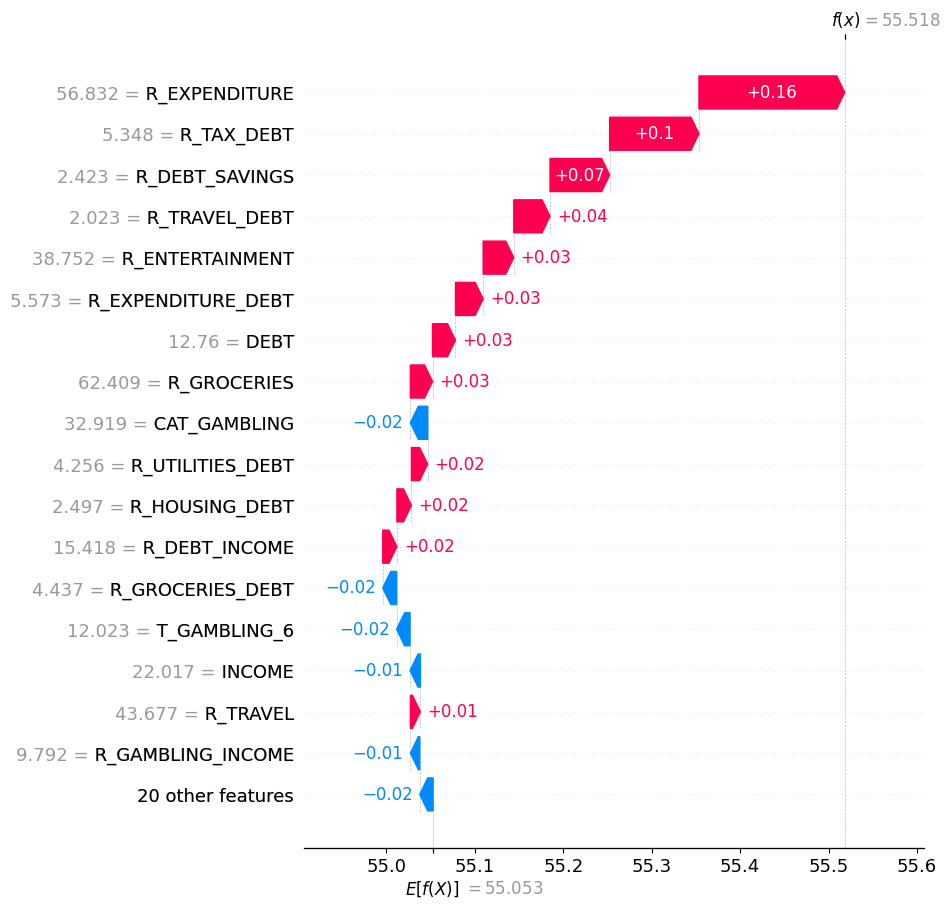

In [56]:
shap.plots.waterfall(100*shap_values.mean(axis=0), max_display=18)

In [21]:
shap.plots.force(shap_values[0:167])

In [22]:
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Get feature names
feature_names = X_valid.columns  # Assuming X_valid is a pandas DataFrame

# Combine feature names with corresponding mean SHAP values
feature_importances = dict(zip(feature_names, mean_shap_values))

# Sort feature importances by magnitude
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Print or process sorted feature importances
print("Feature Importances:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

Feature Importances:
R_DEBT_INCOME: 0.11736865031712683
R_EXPENDITURE: 0.011903809515043558
R_TAX_DEBT: 0.011305788496038237
R_ENTERTAINMENT: 0.008850037988784214
R_UTILITIES_DEBT: 0.007757137382270825
R_EXPENDITURE_DEBT: 0.005227764795407304
R_DEBT_SAVINGS: 0.004696879621987132
R_TRAVEL_DEBT: 0.004458907015963853
CAT_GAMBLING: 0.004085879568411592
R_ENTERTAINMENT_DEBT: 0.00406808222792632
T_GAMBLING_6: 0.003700066473194605
R_GROCERIES_DEBT: 0.002446147318648503
R_GROCERIES: 0.002180807692934326
R_GAMBLING_INCOME: 0.002125904402271798
INCOME: 0.0018929789219293148
R_TRAVEL: 0.001666614067232105
R_HEALTH_DEBT: 0.0013002626326262302
T_TRAVEL_12: 0.0010476754648724763
R_EXPENDITURE_INCOME: 0.0009213043241108826
R_HOUSING_DEBT: 0.0009130448370665413
DEBT: 0.0008663147320272098
T_TAX_12: 0.000758375639015122
T_ENTERTAINMENT_6: 0.0006560617760020236
T_EXPENDITURE_12: 0.0006351706083389574
T_CLOTHING_12: 0.0004457436404527732
R_TAX_SAVINGS: 0.0003704821039298802
R_TAX_INCOME: 0.00036717849134

In [33]:
a = np.array([x[1] for x in sorted_feature_importances])
a.cumsum() / a.sum()

array([0.57593653, 0.63434939, 0.68982772, 0.7332555 , 0.77132034,
       0.79697336, 0.82002129, 0.84190147, 0.86195118, 0.88191356,
       0.90007006, 0.91207348, 0.92277486, 0.93320683, 0.94249582,
       0.95067401, 0.9570545 , 0.96219552, 0.96671642, 0.9711968 ,
       0.97544787, 0.97916928, 0.98238862, 0.98550545, 0.98769274,
       0.98951073, 0.9913125 , 0.99302884, 0.99473449, 0.99602653,
       0.99689583, 0.99768042, 0.99842474, 0.99912362, 0.99960722,
       0.99987407, 1.        ])

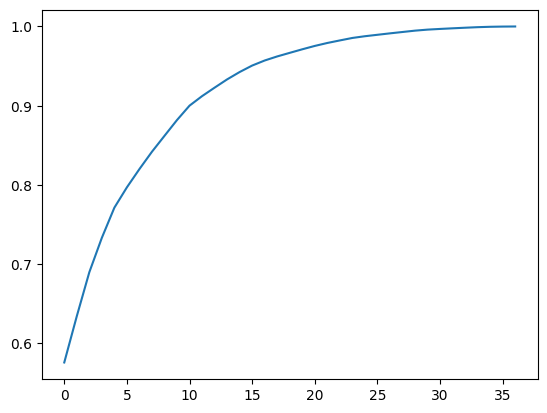

In [35]:
plt.plot(a.cumsum() / a.sum())

In [34]:
a.cumsum()

array([0.11736865, 0.12927246, 0.14057825, 0.14942829, 0.15718542,
       0.16241319, 0.16711007, 0.17156898, 0.17565485, 0.17972294,
       0.183423  , 0.18586915, 0.18804996, 0.19017586, 0.19206884,
       0.19373546, 0.19503572, 0.19608339, 0.1970047 , 0.19791774,
       0.19878406, 0.19954243, 0.2001985 , 0.20083367, 0.20127941,
       0.20164989, 0.20201707, 0.20236684, 0.20271443, 0.20297773,
       0.20315488, 0.20331477, 0.20346646, 0.20360888, 0.20370743,
       0.20376181, 0.20378747])

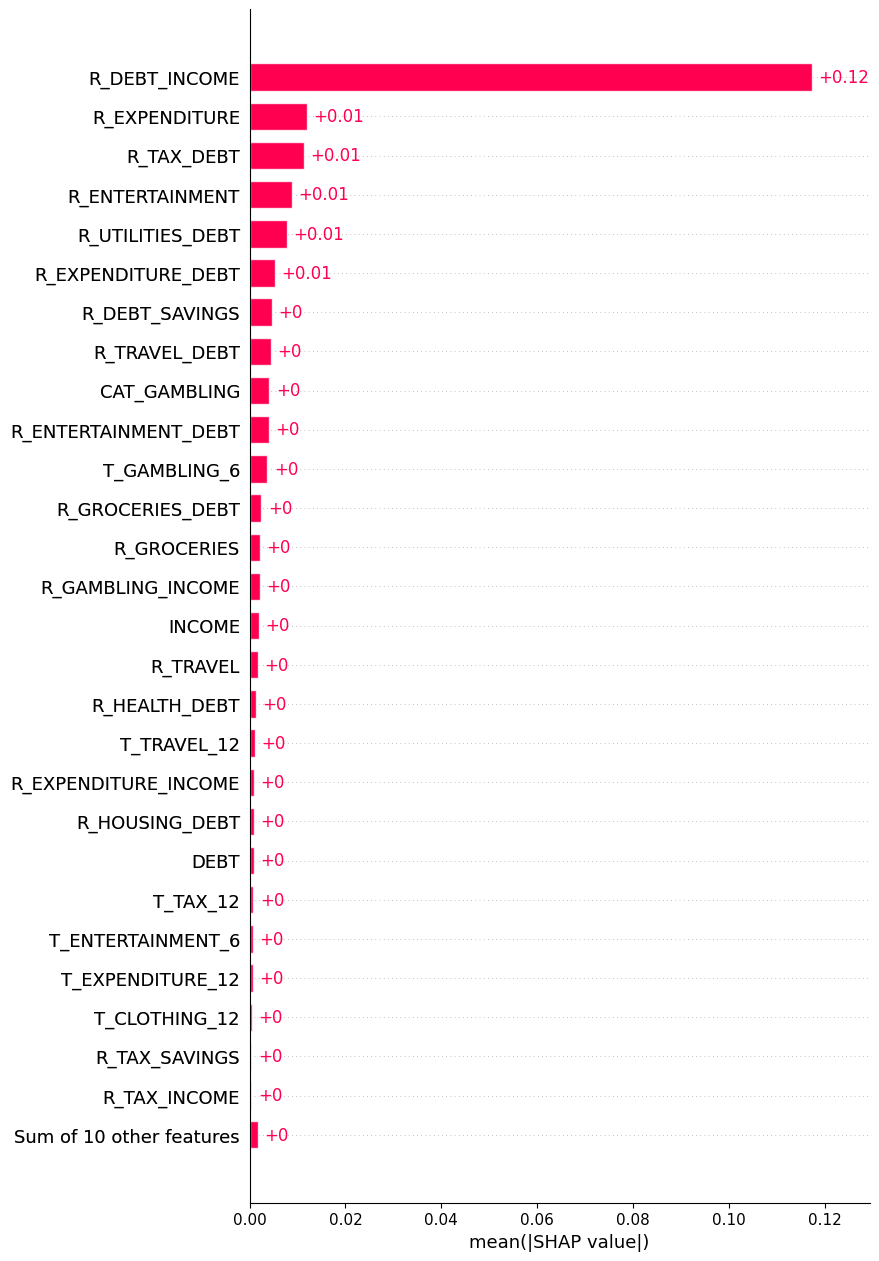

In [23]:
shap.plots.bar(shap_values,max_display=28)

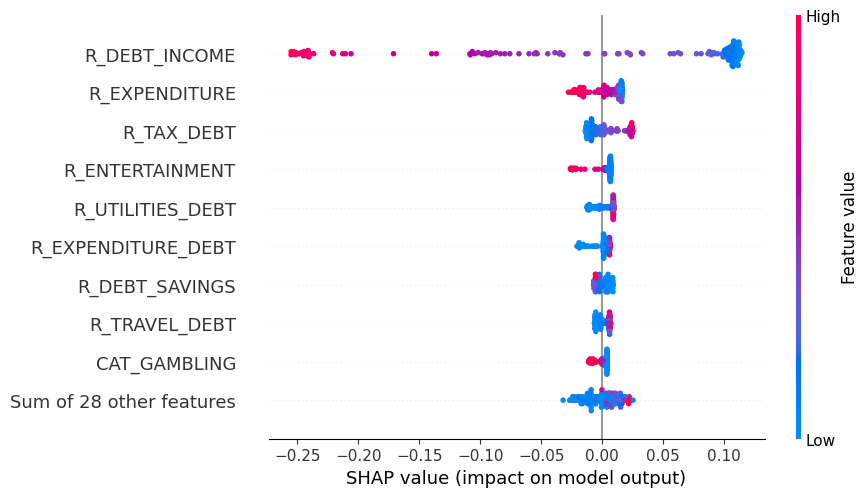

In [24]:
shap.plots.beeswarm(shap_values)

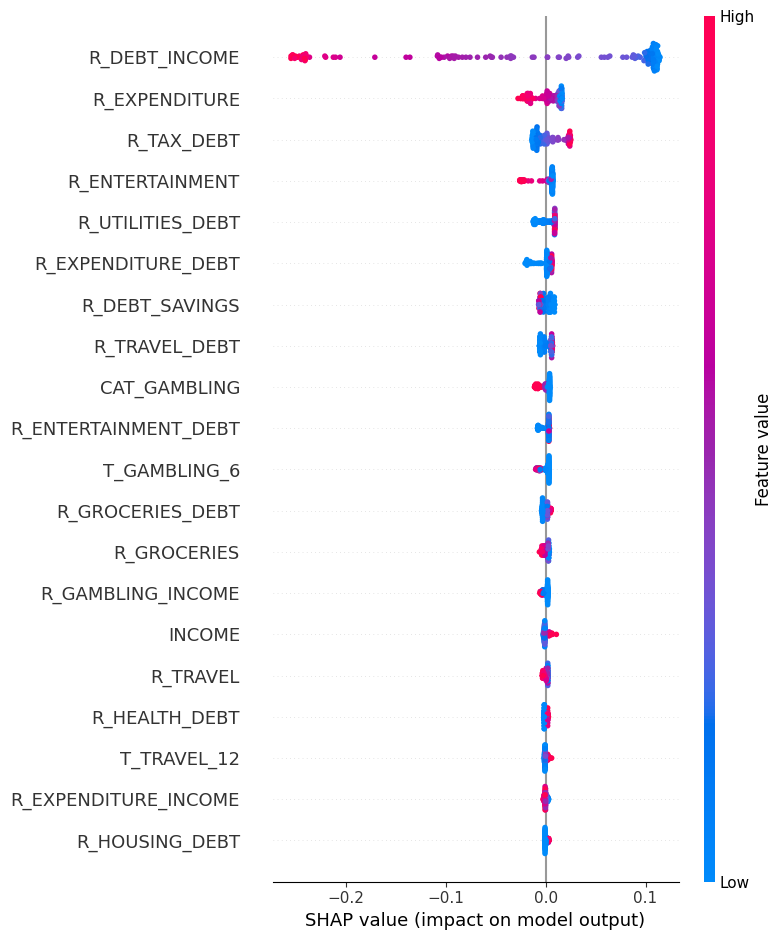

In [25]:


shap.summary_plot(shap_values, X_valid)



# Positive SHAP Values: When a feature has a positive SHAP value for certain observations, 
#     it means that in those cases, the feature's value has contributed to increasing the predicted credit score.
#     For example, a high income might generally be associated with a higher credit score, reflecting a borrower's ability to repay debts.

# Negative SHAP Values: Conversely, a negative SHAP value for the feature in other observations 
#     indicates that it has contributed to lowering the predicted credit score. An example might be 
#     the use of the same income feature but at a lower value, suggesting a lower capacity for debt repayment and therefore a lower credit score.

In [26]:
# Calculate prediction explanations for a single instance
instance_index = 0
instance_explanation = explainer.shap_values(X_valid.iloc[instance_index])

# Print prediction explanation for the instance
print("Prediction Explanation for Instance", instance_index)
print(instance_explanation)


/home/erikaramovich/Documents/MtqiZark/credit_score_prediction/venv/lib/python3.11/site-packages/catboost/core.py:937: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(data[0], Iterable):


CatBoostError: /src/catboost/catboost/libs/data/model_dataset_compatibility.cpp:72: Feature CAT_CREDIT_CARD is present in model but not in pool.

In [ ]:
# last Spo predcition scores
# {'learning_rate': 0.6033700598512344,
#  'depth': 4,
#  'l2_leaf_reg': 38.92268508672135,
#  'min_child_samples': 123,
#  'iterations': 497}

In [ ]:
print("Training set metrics:")
print(mean_squared_error(y_train, pred_train))
print(r2_score(y_train, pred_train))
print(mean_absolute_error(y_train, pred_train))
print(np.sqrt(mean_squared_error(y_train, pred_train)))

print("Validation set metrics:")
print(mean_squared_error(y_valid, pred_valid))
print(r2_score(y_valid, pred_valid))
print(mean_absolute_error(y_valid, pred_valid))
print(np.sqrt(mean_squared_error(y_valid, pred_valid)))

Training set metrics:
0.0033007569106272847
0.8083648988418621
0.04264708889757113
0.057452214149041156
Validation set metrics:
0.0038316607172604635
0.771700788589567
0.04460615947626148
0.06190040966956894


In [ ]:
# print("Training set metrics:")
# print(mean_squared_error(y_train, pred_train))
# print(r2_score(y_train, pred_train))
# print(mean_absolute_error(y_train, pred_train))
# print(np.sqrt(mean_squared_error(y_train, pred_train)))

# print("Validation set metrics:")
# print(mean_squared_error(y_valid, pred_valid))
# print(r2_score(y_valid, pred_valid))
# print(mean_absolute_error(y_valid, pred_valid))
# print(np.sqrt(mean_squared_error(y_valid, pred_valid)))


Training set metrics:
0.0020861356718066227
0.8788832890998062
0.03443580505288086
0.04567423422244343
Validation set metrics:
0.0035043265612778513
0.7912041150041146
0.041729216269541645
0.05919735265430247


In [ ]:
from preprocessing.minmax_scaler import MinMaxScaling

predicted = MinMaxScaling().inverse_transform(pred_valid)
actual = MinMaxScaling().inverse_transform(y_valid)
print(mean_squared_error(actual, predicted))
print(r2_score(actual, predicted))
print(mean_absolute_error(actual, predicted))
print(np.sqrt(mean_squared_error(actual, predicted)))

814.308367292911
0.771700788589567
20.563439518556546
28.53608885767128


In [ ]:
# Training set metrics:
# 0.0010818507548037424
# 0.9314771548203596
# 0.024995828691825792
# 0.03289149973479079
# Validation set metrics:
# 0.003781104669540127
# 0.7910454968147861
# 0.04361746360243078
# 0.061490687665207704

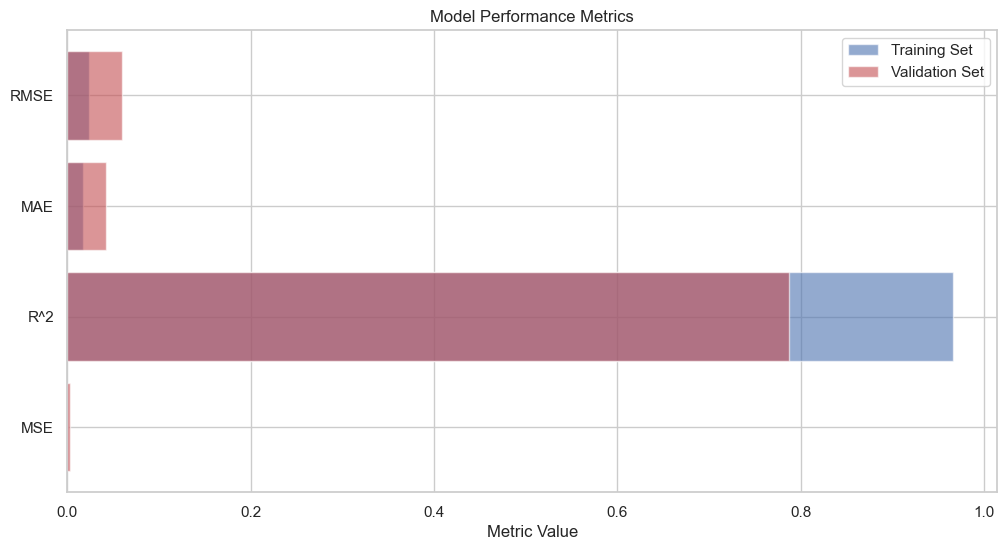

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot the metrics
def plot_metrics(y_true_train, y_pred_train, y_true_valid, y_pred_valid):
    # Metrics calculation
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)

    mse_valid = mean_squared_error(y_true_valid, y_pred_valid)
    r2_valid = r2_score(y_true_valid, y_pred_valid)
    mae_valid = mean_absolute_error(y_true_valid, y_pred_valid)
    rmse_valid = np.sqrt(mse_valid)

    # Plotting
    metrics = ['MSE', 'R^2', 'MAE', 'RMSE']
    train_values = [mse_train, r2_train, mae_train, rmse_train]
    valid_values = [mse_valid, r2_valid, mae_valid, rmse_valid]

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    plt.barh(metrics, train_values, color='b', alpha=0.6, label='Training Set')
    plt.barh(metrics, valid_values, color='r', alpha=0.6, label='Validation Set')

    plt.xlabel('Metric Value')
    plt.title('Model Performance Metrics')
    plt.legend()
    plt.show()

# Call the function with your prediction results
plot_metrics(y_train, pred_train, y_valid, pred_valid)


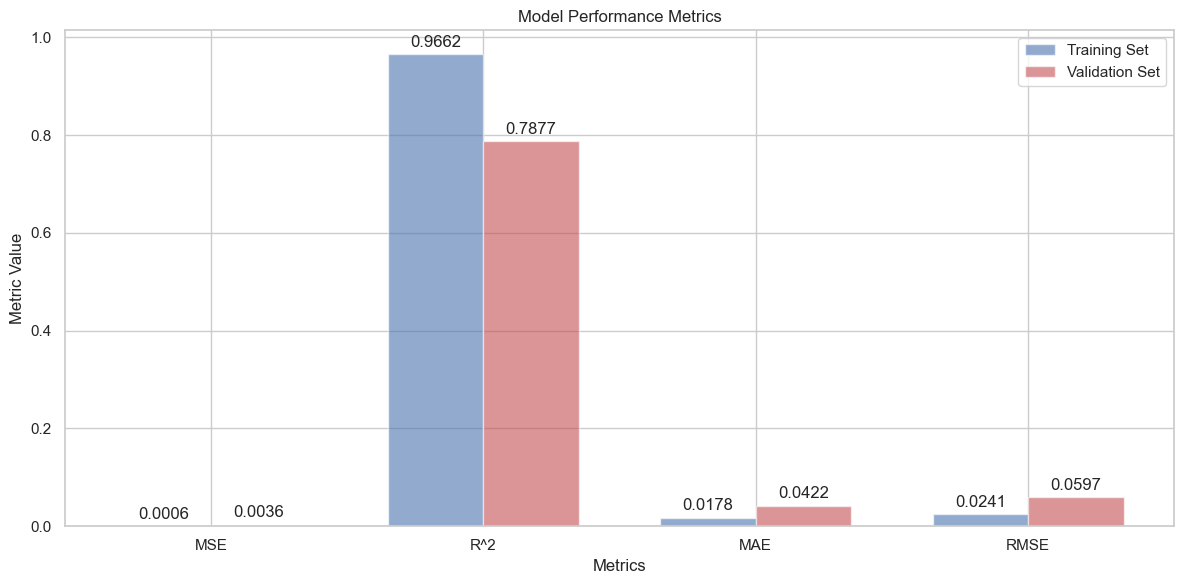

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define a function to plot the metrics
def plot_metrics(y_true_train, y_pred_train, y_true_valid, y_pred_valid):
    # Metrics calculation
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)

    mse_valid = mean_squared_error(y_true_valid, y_pred_valid)
    r2_valid = r2_score(y_true_valid, y_pred_valid)
    mae_valid = mean_absolute_error(y_true_valid, y_pred_valid)
    rmse_valid = np.sqrt(mse_valid)

    # Prepare data for plotting
    metrics = ['MSE', 'R^2', 'MAE', 'RMSE']
    train_values = [mse_train, r2_train, mae_train, rmse_train]
    valid_values = [mse_valid, r2_valid, mae_valid, rmse_valid]
    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, train_values, width, label='Training Set', color='b', alpha=0.6)
    rects2 = ax.bar(x + width/2, valid_values, width, label='Validation Set', color='r', alpha=0.6)

    # Add labels, title, and legend
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Metric Value')
    ax.set_title('Model Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Attach a text label above each bar in rects, displaying its height
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.4f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Call the function with your prediction results
plot_metrics(y_train, pred_train, y_valid, pred_valid)


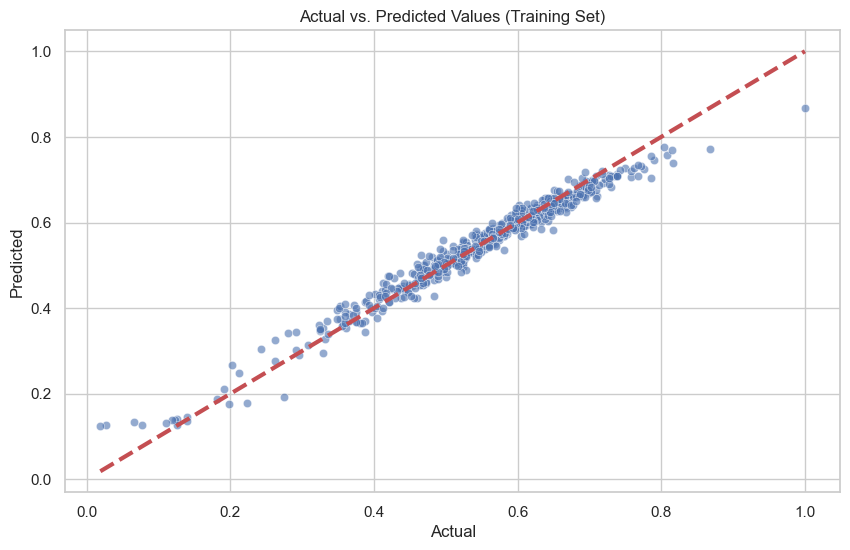

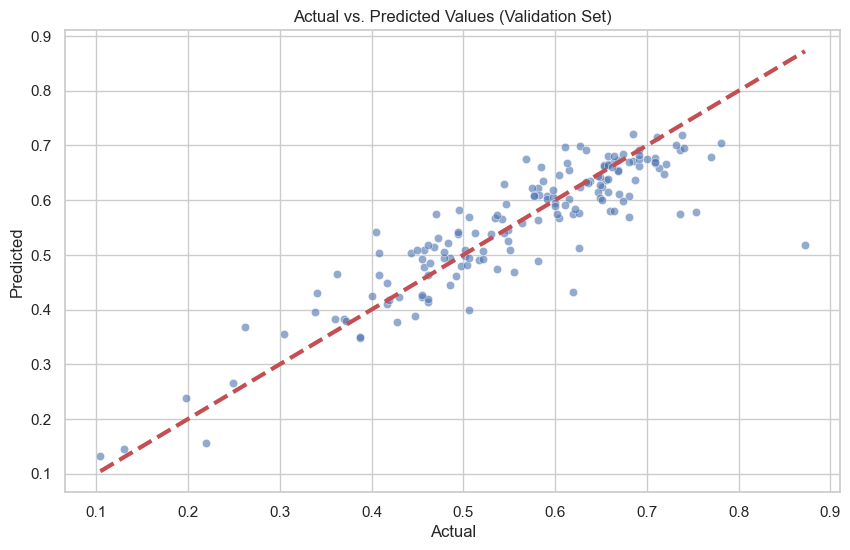

In [ ]:
def plot_actual_vs_predicted(y_true, y_pred, dataset_type='Training'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=3) # Diagonal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted Values ({dataset_type} Set)')
    plt.show()

plot_actual_vs_predicted(y_train, pred_train, 'Training')
plot_actual_vs_predicted(y_valid, pred_valid, 'Validation')


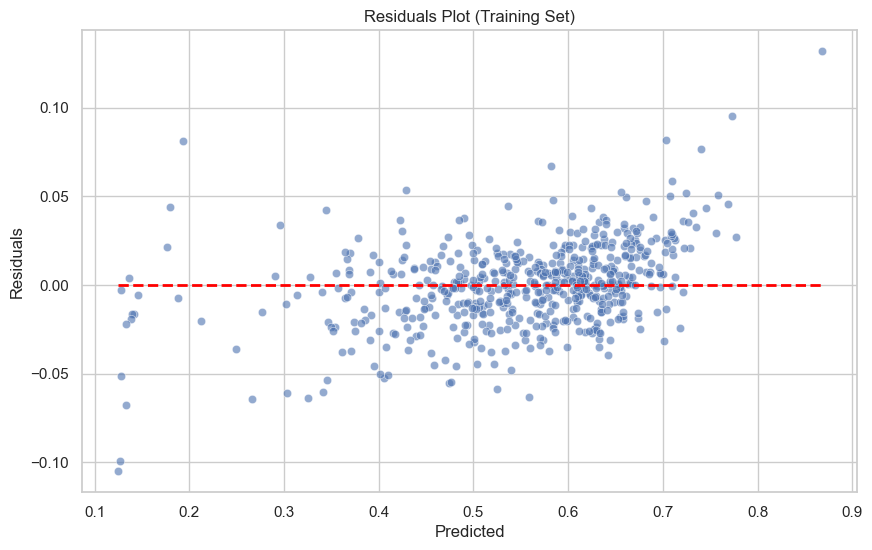

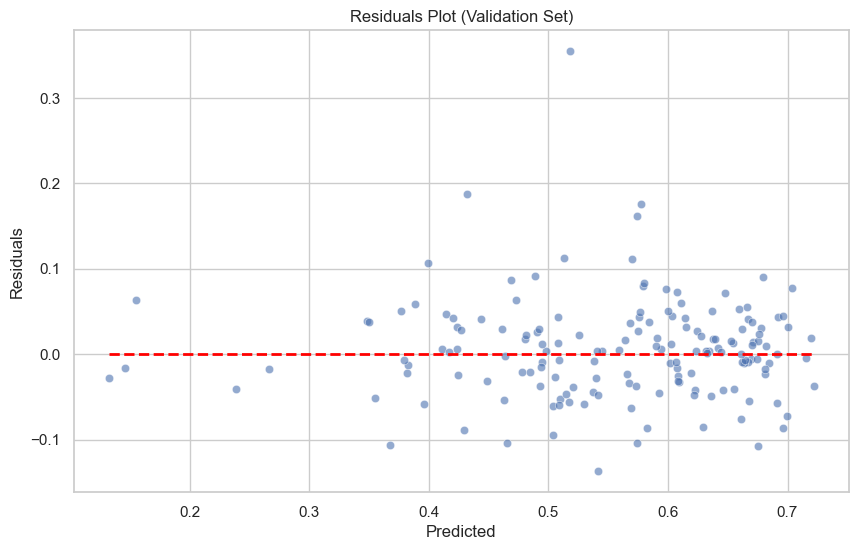

In [ ]:
def plot_residuals(y_true, y_pred, dataset_type='Training'):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--', lw=2)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot ({dataset_type} Set)')
    plt.show()

plot_residuals(y_train, pred_train, 'Training')
plot_residuals(y_valid, pred_valid, 'Validation')


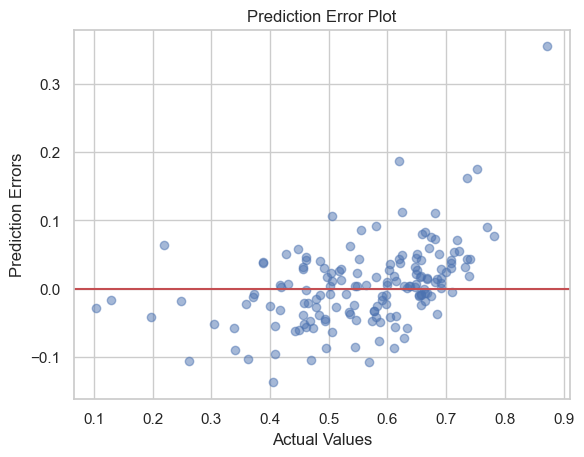

In [ ]:
import matplotlib.pyplot as plt

# Calculate prediction errors
errors = y_valid - pred_valid

# Plot prediction errors
plt.scatter(y_valid, errors, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Prediction Errors')
plt.title('Prediction Error Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()
